In [1]:
# Package Imports
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import MultiLineString, LineString, Polygon, Point
from shapely import wkt
from shapely.affinity import rotate, scale

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show

import pulp

from imp import reload

# to load the interactive plotting version
#matplotlib widget
# or regular
%matplotlib inline

# Importing my modules
import data_loading, set_cover, plotting, geometry_operations, optimization_functions

/tmp/ipykernel_30096/1301741632.py:20: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


##### Reading the TIF and CSV Data

In [2]:
forest_area_gpd = gpd.GeoDataFrame(pd.DataFrame(
    {"name": ["area1", "area2", "area3", "area4", "area5"]}), 
    geometry=data_loading.read_tif("Resources_Organized/tif/Bestand3.tif"))
#forest_area_gpd.plot()

#load the data and show that we have correctly parsed the CSV
bestand_3_csv = data_loading.read_csv("Resources_Organized/csv/Bestand3_h.csv")
bestand_3_csv = data_loading.format_csv(bestand_3_csv)
bestand_3_csv.head

<bound method NDFrame.head of              x          y       z     id          BHD      h crownLength  \
0   -68.216701  61.395624 -52.341    1.0  56,14971429  38,74       37,64   
1   -42.198416  22.294888 -26.887    2.0            4   9,54           0   
2   -35.660549  48.789428 -39.520    3.0   34,5655619  33,07       15,77   
3   -63.811228  60.685099 -52.156    4.0      32,0572  33,07       10,92   
4   -12.395044  77.242318 -42.336    5.0  38,38882324  24,77           0   
..         ...        ...     ...    ...          ...    ...         ...   
628   4.503100  96.760800 -52.333  640.0         63,8  20,51           0   
629   3.241200  92.597600 -48.579  641.0           10  28,74           0   
630  11.452980  27.791890  -9.873  642.0        44,56   31,1        25,9   
631  10.763840  30.705970 -11.548  643.0        28,66  24,77           0   
632   9.759666  89.327680 -42.205  647.0           10  29,32           0   

    crownArea crownVolume crownDiameter  
0        34,8  

#### Adding trees to the map

<AxesSubplot:xlabel='X coordinate', ylabel='Y coordinate'>

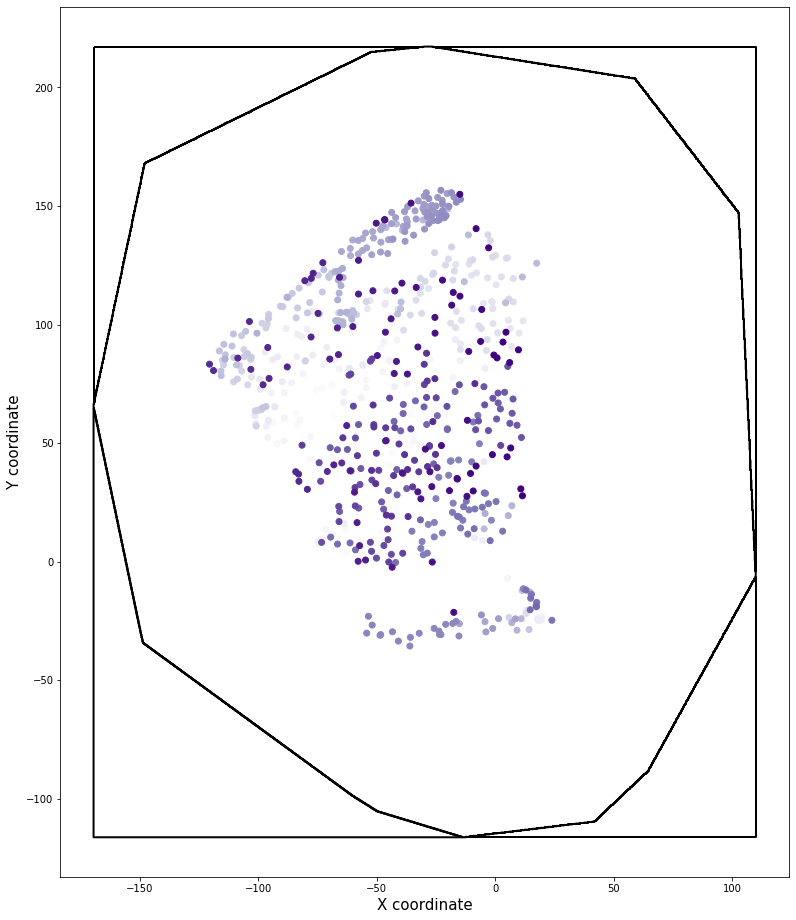

In [3]:
point_list = [Point(xy) for xy in zip(bestand_3_csv["x"], bestand_3_csv["y"])]
tree_gpd = gpd.GeoDataFrame(data=bestand_3_csv,geometry=point_list)

#verify that the boundary and trees add up
fig, ax = plt.subplots(figsize = (20,16))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
tree_gpd.plot(cmap = 'Purples',ax=ax)
forest_area_gpd.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)

#### Joining and Overlaying Anchor Areas and Road on the Map

Recording coordinates with interactive figure

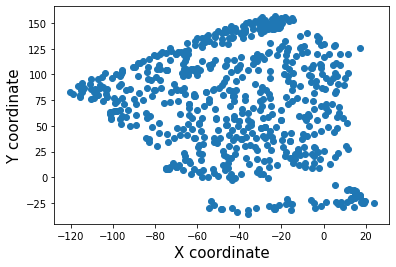

In [4]:
reload(plotting)

coords = []
fig, ax = plt.subplots()
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
ax.scatter(tree_gpd["x"],tree_gpd["y"])

cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [5]:
fig.canvas.mpl_disconnect(cid)

Create the extra_geometry_gpd from manual coordinates

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


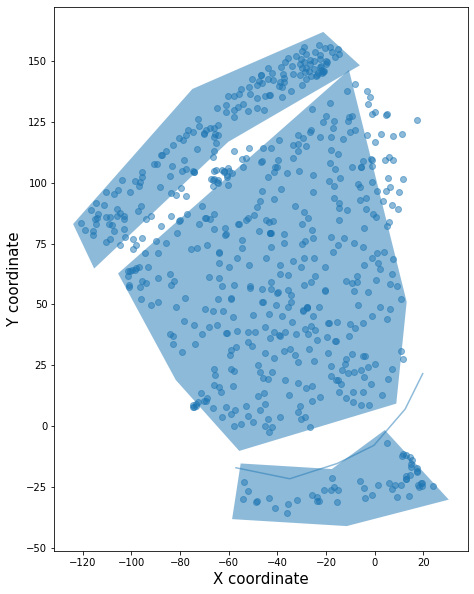

In [6]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
inner_forest = Polygon([Point(xy) for xy in [(-105.43005197808363, 62.73802056488026), (-10.557896233758669, 146.34023494632802), (13.160142702322588, 51.07259530235265), (8.890895693827957, 9.27148811162877), (-55.62217021231302, -10.17088732591722), (-81.71201304200238, 18.992675830401765)]])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors","inner_forest"],"geometry":[uphill_anchors,road,downhill_anchors,inner_forest]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

plotting.plot_gdfs([tree_gpd,extra_geometry_gpd])

#### Generating Eligible Trees and Road Pathway

Getting the points along the road

/tmp/ipykernel_30096/1820587770.py:5: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]


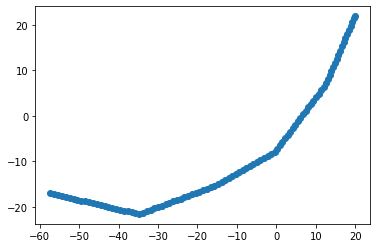

In [7]:
# thanks to https://stackoverflow.com/questions/62990029/how-to-get-equally-spaced-points-on-a-line-in-shapely
road_geometry = extra_geometry_gpd.loc['road'].geometry
distance_delta = 1
distances = np.arange(0, road_geometry.length, distance_delta)
road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]

#reset the figure
fig.data = []
plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

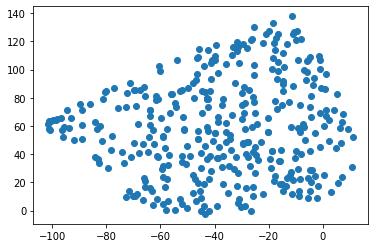

In [8]:
# get the eligible anchor and target trees inside the polygon
uphill_anchor_trees = geometry_operations.get_contained_elements(tree_gpd,extra_geometry_gpd.loc["uphill_anchors"].geometry)
downhill_anchor_trees = geometry_operations.get_contained_elements(tree_gpd,extra_geometry_gpd.loc["downhill_anchors"].geometry)
inner_forest_trees = geometry_operations.get_contained_elements(tree_gpd, extra_geometry_gpd.loc["inner_forest"].geometry)

# and check if the anchor trees look good
plotting.plot_scatter_xy(inner_forest_trees)

#### Generating Possible Lines

Setting and rotating the slope line

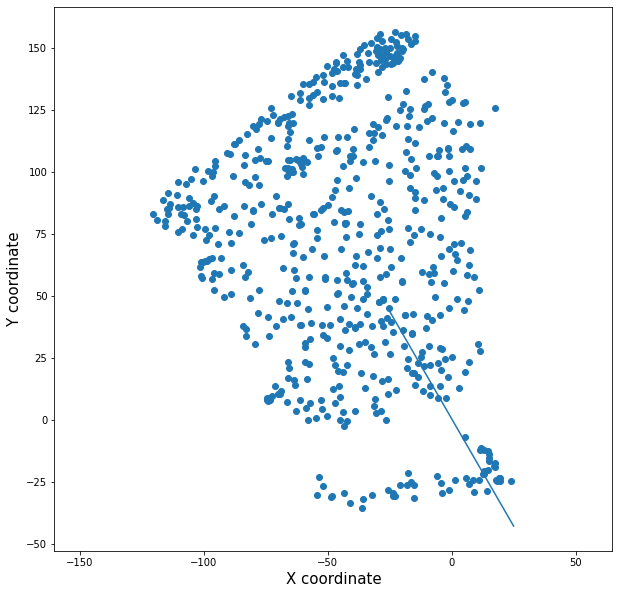

In [9]:
slope_degree = 30
# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

ax = plotting.plot_equal_axis(slope_line)
ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

Generating the possible lines depending on the slope

we have n lines:  950


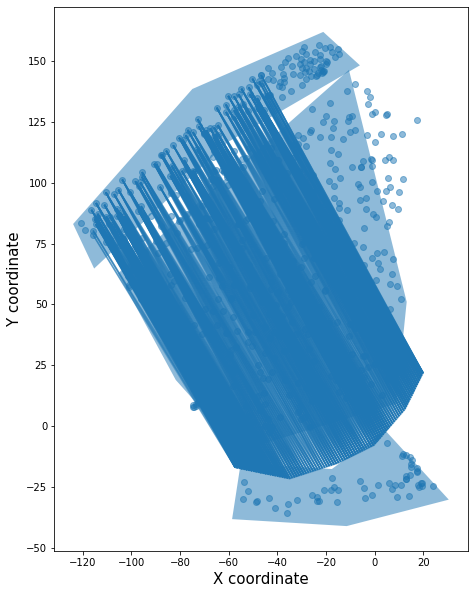

In [10]:
reload(geometry_operations)
max_deviation = 2
possible_lines, slope_deviation = geometry_operations.generate_possible_lines(road_points,downhill_anchor_trees,slope_line, max_deviation)
print("we have n lines: ",len(possible_lines))

line_gdf = gpd.GeoDataFrame(geometry=possible_lines)
#add the length of each line
line_gdf["line_length"] = line_gdf.geometry.length
line_gdf["slope_deviation"] = slope_deviation

plotting.plot_gdfs([tree_gpd,extra_geometry_gpd,line_gdf])

#### Optimization Setup

Compute the trees covered by each line

In [11]:
buffer_size = 5
min_trees_covered = 10

overall_coverage_series = geometry_operations.compute_points_covered_per_row(
    tree_gpd, line_gdf, buffer_size, min_trees_covered)

# and unzip the results
x,y = zip(*overall_coverage_series)
line_gdf["id_trees_covered"] = list(x)
line_gdf["amount_trees_covered"] = list(y)

Which trees are in which buffer

In [12]:
line_gdf["buffer"] = line_gdf.apply(
        lambda row: row.geometry.buffer(5), axis=1)

test_buffer = line_gdf.loc[0,"buffer"]
buffer_contains = tree_gpd.geometry.intersects(test_buffer)
true_list, = np.where(buffer_contains)

Apply Line Cost Function

In [13]:
line_gdf["buffer_width"] = [buffer_size]*len(line_gdf)

#x0 = buffer size
#x1 = line length
#x2 = slope_deviation
#x3 = trees_covered
def cost_function(x0,x1):
    return (x0-10)**2+(x1-30)#+x2**2
    
line_gdf["line_cost"] = cost_function(line_gdf["buffer_width"],line_gdf["line_length"])

#and set each line as active for later optimization process
line_gdf["line_active"] = 1

##### PyMOO Preparation

In [14]:
# set the index of the line_gdf explicitly to make sure we have our x_j
line_gdf['index_column'] = line_gdf.index

# Generate a numpy array from the line_gdf which can be parsed by PYMOO
columns_array = line_gdf[['line_length', 'slope_deviation','amount_trees_covered', 'buffer_width', 'line_cost',
       'line_active','id_trees_covered',"index_column"]].to_numpy()

In [15]:
# Again, get the list of line IDs that cover this tree as constraint set (for PyOMO originally)
constraint_list = []
highest_tree_id = max(line_gdf["id_trees_covered"].max()).astype(int)

# for each tree id
for id in range(0,highest_tree_id):
    # get the index of this line
    # if the tree id is in the trees covered by this line
    # add the list of line ids that cover this tree id as set to the constraint list
    constraint_list.append({index_column if id in id_trees_covered else None for index_column, id_trees_covered in zip(line_gdf["index_column"],line_gdf["id_trees_covered"])})

In [16]:
#Further preparation - create distance/cost matrix

# Set up the inner_trees list as gdf
inner_forest_trees_gdf = gpd.GeoDataFrame(geometry=inner_forest_trees)

# Computing the distance from all lines to all points

#create df with nrow = ntrees
distances_df = pd.DataFrame(index=range(0,len(inner_forest_trees_gdf)))

# compute the distance to each tree for every row
for line in line_gdf.iterrows():
    distances = inner_forest_trees_gdf.geometry.distance(line[1].geometry)
    distances_df[line[1]["index_column"]] = distances

#pivot the table and convert to numpy matrix (solver expects it this way)
cost_matrix = distances_df.to_numpy()

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.sort_values(by="index_column").reset_index()
demand_points_gdf = inner_forest_trees_gdf.reset_index()

/tmp/ipykernel_30096/2388808152.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  distances_df[line[1]["index_column"]] = distances
/tmp/ipykernel_30096/2388808152.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  distances_df[line[1]["index_column"]] = distances
/tmp/ipykernel_30096/2388808152.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

#### Back to MOO PyOMO

Creating our custom problem with constraints - as per Obsidian notes:
- Obj Func v3:
	- $max(\sum(activeindex*line(-linecost+\sum(linetreeactiveindex*(treeprofit-linetreedistance)))))$
	- line X activeindex deckt den Profit durch die Linie ab
	- linetreeactiveindex X profit stellt sicher, dass der Baum nur einmal abgedeckt wird
- Matrices:
	- Constraint 1 - Linien nur einmal aktivieren
		- Lineactiveindex = $[l1*x1+l2*x2...]$
		- x1 = whether this line is active
	- Constraint: - Baum-Linie Verbindung nur einmal aktivieren
		- linetreeactiveindex = $[[l1*t1*y1+l1*t2*y2+...],[l2*t1*y1+l2*t2*y2+....]$
		- y1 = whether this tree is covered by this line
	- linetreecost, linetreedistance

LineActiveIndex:
l1,l2,l3,....

LineTreeActiveIndex:
l1t2,l1t2,l1t3,..,l2t1,l2t2,...

l1*t1+l2*t1+... = 0


TreeProfit:
t1,t2,t3,...

#### Extend SpOPT

add wheights to the optimization function, rest is the same

1. LSCP_from cost_matrix
2. FacilityModelBuilder.add_facility_integer_variable (as "fac_vars)
3. lscp_aij <- matrix that defines if demand points is reachable by facility
4. lscp.add_obj <- minimize x1+x2+... (that is, fac1+fac2+...)
5. FacilityModelBuider.add_set_cover_constraint <- add constraint to ensure each demand point is covered once

My modification:

4. lscp.add_weighted_objective
    -> add *line_cost to the objective function in /Coverage/LSCP/add_wheighted_obj like here: https://stackoverflow.com/questions/53301689/python-pulp-constraint-doubling-the-weight-of-any-one-variable-which-contribut

In [17]:
from spopt.locate.coverage import LSCP
from spopt.locate import PMedian

service_radius = 30
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "LSCP"

# create the nr of possible facilities and clients 
r_fac = range(cost_matrix.shape[1])
r_cli = range(cost_matrix.shape[0])
# and a mocked up facility cost
fac_cost = [100 for fac in r_fac]
cli_demand = [100 for cli in r_cli]

# init the LSCP with name and the problem - this only gives it a name and tells it to minimize the obj function
model = pulp.LpProblem(name, pulp.LpMinimize)
# modified to p-median style - no wheights for now, just the cost matrix unfolded to one long vector
weights = np.reshape(cli_demand, (cost_matrix.shape[0], 1))
aij = weights * cost_matrix

lscp = PMedian(name, model, aij)

# Add a sum of facilities as fac_vars
# FacilityModelBuilder.add_facility_integer_variable(lscp, r_fac, "x[{i}]")
var_name = "y[{i}]"
fac_vars = [
    pulp.LpVariable(
        var_name.format(i=fac), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for fac in r_fac
]
setattr(lscp, "fac_vars", fac_vars)

# Add the sum of facilities*clients
# FacilityModelBuilder.add_client_assign_integer_variable(p_median, r_cli, r_fac, "z[{i}_{j}]")
var_name = "z[{i}_{j}]"
cli_assgn_vars = [
    [
        pulp.LpVariable(
            var_name.format(i=i, j=j), lowBound=0, upBound=1, cat=pulp.LpInteger
        )
        for j in r_fac
    ]
    for i in r_cli
]
setattr(lscp, "cli_assgn_vars", cli_assgn_vars)



# Add the objective functions
# lscp - minimize the number of facilities (fac_vars) + minimize distance between client_assigned_distance
# this should also be weighted at some point to reflect the cost of different lines
cli_assgn_vars = getattr(lscp, "cli_assgn_vars")
fac_vars = getattr(lscp, "fac_vars")
lscp.problem += pulp.lpSum([
            lscp.aij[cli][fac] * cli_assgn_vars[cli][fac]
            for cli in r_cli
            for fac in r_fac
        ]) + pulp.lpSum([
            fac_vars[fac]*fac_cost[fac] for fac in r_fac]
        ), "objective function"


# Try again with the assignment/demand constraint
# does not seem to work - each factory has all clients?
for cli in r_cli:
    lscp.problem += pulp.lpSum([cli_assgn_vars[cli][fac] for fac in r_fac]) == 1


# Add opening/shipping constraint
for cli in r_cli:
    for fac in r_fac:
        lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0

# add set covering constraint - for each 
# for i in r_cli:
#     model += (
#         pulp.lpSum([lscp.ni[i][fac] * fac_vars[fac] for fac in r_fac]) >= 1
#     )

lscp = lscp.solve(solver)

In [20]:
print(a)

[[], [], [], [35, 83, 127], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [34, 71, 130, 187, 300], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [41, 48, 81], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [15, 26, 56, 128, 131, 186, 302], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [132], [], [], [12, 129, 301, 303], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [82, 183, 185, 257], [17, 39, 133, 308], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [23, 43, 55, 58, 241, 309], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [20, 209, 

In [18]:
a = lscp.fac2cli
b = lscp.cli2fac

covered_facs = 

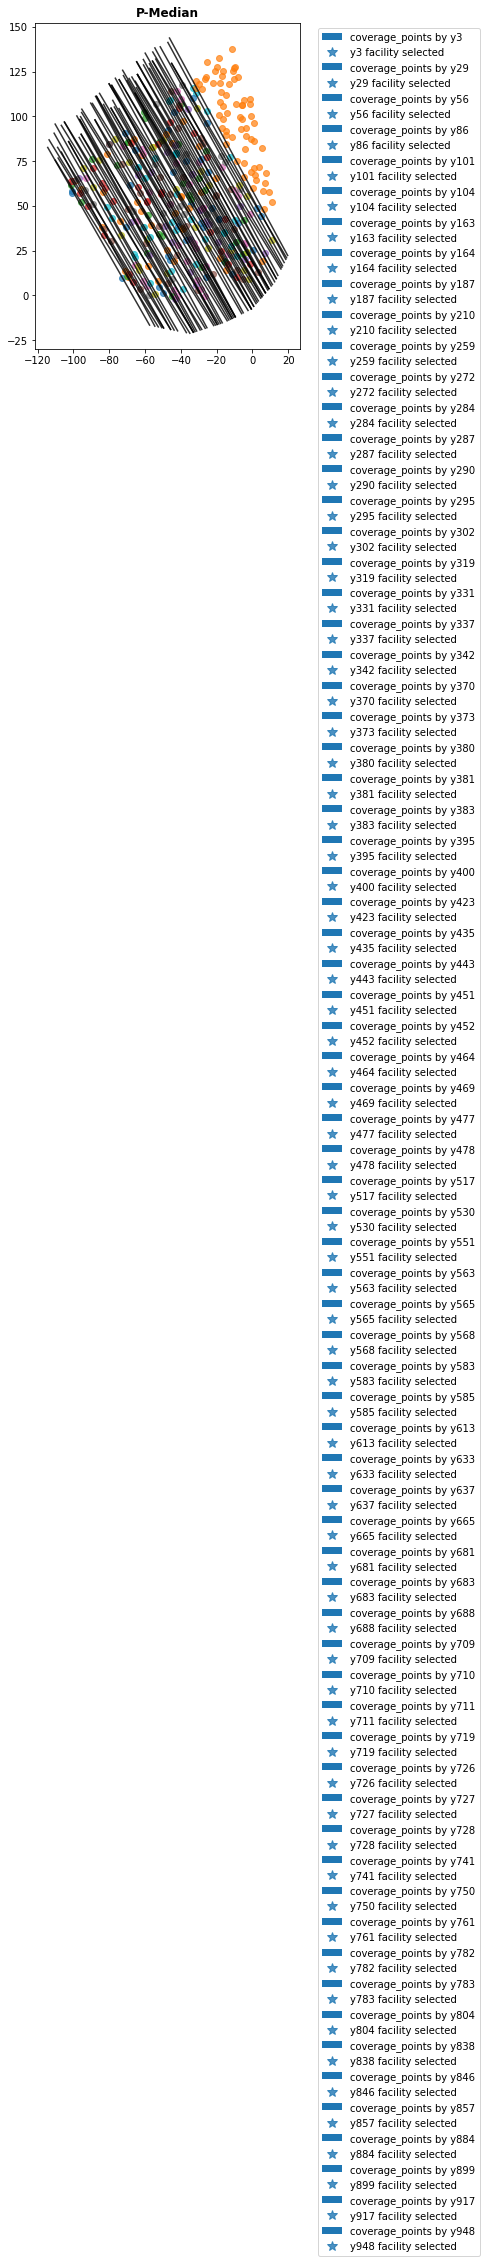

In [22]:
#plotting.plot_lcsp_results(lscp, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "LSCP", lscp.problem.objective.value())
reload(plotting)
plotting.plot_p_median_results(lscp, facility_points_gdf, demand_points_gdf)